# Python Workshop week 8

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas_profiling

from tqdm.notebook import tqdm

# 0. Preparing the data

In [2]:
ls data

gender_submission.csv  test.csv  train.csv


In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

# 1. Inspecting, cleaning & preparing the data

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### [Parenthesis] Profile Report

Documentation https://github.com/pandas-profiling/pandas-profiling
Install with 
```bash
conda install -c conda-forge pandas-profiling
```

In [8]:
# df.profile_report()

Transforming `Sex` into dummies, renaming the created column

In [9]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df = df.rename(columns={'Sex_male':'is_male'})

Let's do what this dataset is mostly used for: Exercise how to write a classfier predicting who survives.
We're focussing only on
* `SibSp`: # of siblings / spouses aboard the Titanic
* `Parch` : # of parents / children aboard the Titanic
* `Pclass` : Ticket class (1st, 2nd, 3rd)
* `Fare` : Passenger fare
* `Age` : Passenger's age
* `Sex`: Passenger's sex

### Filter the `survived`, `Fare` and `Age` nan's

In [10]:
df.dropna(subset=['Survived', 'Age']).isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          529
Embarked         2
is_male          0
dtype: int64

In [11]:
df = df.dropna(subset=['Survived', 'Age', 'Fare'])

In [12]:
df_ml = df[['SibSp','Parch','Pclass','Fare','Age', 'Survived']]

### Applying SMOTE, because `survived` is unbalanced

Showing that `survived` is unbalanced

<AxesSubplot:xlabel='Fare', ylabel='Age'>

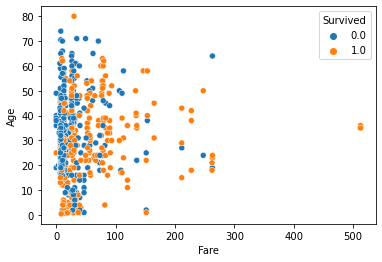

In [13]:
sns.scatterplot(data=df_ml, x='Fare', y='Age', hue='Survived')

using `value_counts()` and then (we got a Series) `to_frame()` to make it look nicer

In [14]:
df_ml['Survived'].value_counts().to_frame()

,Survived
0.0,424
1.0,290


In [15]:
df_ml.head()

,SibSp,Parch,Pclass,Fare,Age,Survived
0,1,0,3,7.2500,22.0,0.0
1,1,0,1,71.2833,38.0,1.0
2,0,0,3,7.9250,26.0,1.0
3,1,0,1,53.1000,35.0,1.0
4,0,0,3,8.0500,35.0,0.0


Looks good already, let's check for nan's one last time

In [16]:
df_ml.isna().sum()

SibSp       0
Parch       0
Pclass      0
Fare        0
Age         0
Survived    0
dtype: int64

In [17]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_res, y_res = sm.fit_resample(df_ml.drop(columns=['Survived']),
                               df_ml['Survived']
                              )
df_ml = pd.concat([X_res, y_res], axis=1)

In [18]:
df_ml

,SibSp,Parch,Pclass,Fare,Age,Survived
0,1,0,3,7.250000,22.000000,0.0
1,1,0,1,71.283300,38.000000,1.0
2,0,0,3,7.925000,26.000000,1.0
3,1,0,1,53.100000,35.000000,1.0
4,0,0,3,8.050000,35.000000,0.0
...,...,...,...,...,...,...
843,0,0,2,12.167638,27.681966,1.0
844,0,0,1,27.459840,41.416064,1.0
845,1,0,1,90.000000,37.838363,1.0
846,0,1,2,14.266558,23.670419,1.0


In [19]:
df_ml['Survived'].value_counts().to_frame()

,Survived
1.0,424
0.0,424


Great! Let's start modeling

# 2. Machine Learning / Modeling

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
sc = StandardScaler()
X = sc.fit_transform(df_ml.drop('Survived', axis=1))
y = df_ml['Survived']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Let's start with one model - the decision tree classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

In [24]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72       141
         1.0       0.72      0.71      0.71       139

    accuracy                           0.72       280
   macro avg       0.72      0.72      0.72       280
weighted avg       0.72      0.72      0.72       280

0.7178571428571429


Text(0.5, 1.0, 'Confusion matrix \n Random Forest')

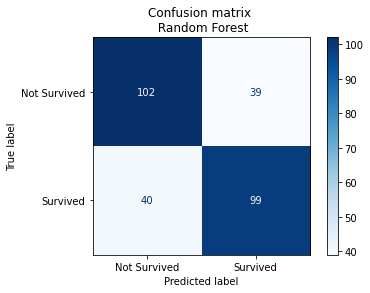

In [25]:
disp = plot_confusion_matrix(rfc, X_test, y_test,
                             # display_labels=class_names,
                             cmap=plt.cm.Blues,
                             # normalize=normalize,
                             display_labels=["Not Survived", "Survived"]
                            )
disp.ax_.set_title('Confusion matrix \n Random Forest')

In [26]:
df_ml['Survived'].value_counts()

1.0    424
0.0    424
Name: Survived, dtype: int64

# Feature engineering

We're trying to create one or more columns out of another existing column, to "enrich" our data with new data, that (important!) are actually new, as in "cannot be used to explain any other original column"... or in mathematical sense: That are not collinear.

This usually contributes to our model being able to perform much better.

In [27]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

In [28]:
# Again dropping rows where survived or age equal nan.
df = df.dropna(subset=['Survived', 'Age'])

### [Parenthesis] dictionary comprehensions & zip()

In [29]:
# a list comprehension
[2 * x for x in range(3)]

[0, 2, 4]

In [30]:
# a dict comprehension
{k:int(k)**2 for k in ['1','2','4','7']}

{'1': 1, '2': 4, '4': 16, '7': 49}

In [31]:
# now zip()!
countries = ['Japan', 'Germany', 'USA', 'China', 'Sweden']
cities = ['Tokyo', 'Berlin', 'Washington', 'Beijing', 'Stockholm']
for country, city in zip(countries, cities):
    print(f"{country}'s capital is {city}")

Japan's capital is Tokyo
Germany's capital is Berlin
USA's capital is Washington
China's capital is Beijing
Sweden's capital is Stockholm


In [32]:
# now dict comprehension used with zip():
{country:city for country, city in zip(countries, cities)}

{'Japan': 'Tokyo',
 'Germany': 'Berlin',
 'USA': 'Washington',
 'China': 'Beijing',
 'Sweden': 'Stockholm'}

Why is this cool?

In [33]:
# that's why:
pd.DataFrame({country:city for country, city in zip(countries, cities)}, index=['captitals'])

,Japan,Germany,USA,China,Sweden
captitals,Tokyo,Berlin,Washington,Beijing,Stockholm


### Back to Titanic

Why I wanted you to show dict comprehensions? Because I want to make use of it, when I quickly rename column names:

In [34]:
# standardizing column names
df = df.rename(columns={col:col.lower().replace(" ","_") for col in df.columns})

### ... and let's actually engineer our features

Let's investigate the 'Name' column

In [35]:
df['name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
885                 Rice, Mrs. William (Margaret Norton)
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: name, Length: 714, dtype: object

In [36]:
df['name'].apply(lambda x: x.split(', ')[1].split(' ')[0]).value_counts()

Mr.          398
Miss.        146
Mrs.         108
Master.       36
Dr.            6
Rev.           6
Col.           2
Major.         2
Mlle.          2
Ms.            1
Don.           1
Sir.           1
Jonkheer.      1
Mme.           1
Capt.          1
Lady.          1
the            1
Name: name, dtype: int64

In [37]:
translate_dct = {'is_mrs':'Mrs.',
                'is_mr':'Mr.',
                'is_miss':'Miss',
                'is_rev':'Rev.',
                'is_master':'Master.',
                'is_dr':'Dr.'}

for new_col, keyword in translate_dct.items():
    df[new_col] = df['name'].apply(lambda x: int(keyword in x))

# Again Training & Evaluating model

In [38]:
df_ml = df[['sibsp',
            'parch',
            'pclass',
            'fare',
            'age',
            'survived',
            'is_mrs',
            'is_mr',
            'is_rev',
            'is_master',
            'is_dr',
           ]]

In [39]:
df_ml

,sibsp,parch,pclass,fare,age,survived,is_mrs,is_mr,is_rev,is_master,is_dr
0,1,0,3,7.2500,22.0,0.0,0,1,0,0,0
1,1,0,1,71.2833,38.0,1.0,1,0,0,0,0
2,0,0,3,7.9250,26.0,1.0,0,0,0,0,0
3,1,0,1,53.1000,35.0,1.0,1,0,0,0,0
4,0,0,3,8.0500,35.0,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
885,0,5,3,29.1250,39.0,0.0,1,0,0,0,0
886,0,0,2,13.0000,27.0,0.0,0,0,1,0,0
887,0,0,1,30.0000,19.0,1.0,0,0,0,0,0
889,0,0,1,30.0000,26.0,1.0,0,1,0,0,0


In [40]:
sc = StandardScaler()
X = sc.fit_transform(df_ml.drop('survived', axis=1))
y = df_ml['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
# accuracies.append({classifier: accuracy_score(y_test, pred)})
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       137
         1.0       0.79      0.72      0.75        99

    accuracy                           0.80       236
   macro avg       0.80      0.79      0.79       236
weighted avg       0.80      0.80      0.80       236

0.8008474576271186


Text(0.5, 1.0, 'Confusion matrix \n Random Forest \n with engineered features')

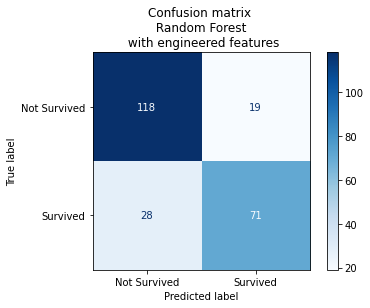

In [41]:
disp = plot_confusion_matrix(rfc, X_test, y_test,
                             # display_labels=class_names,
                             cmap=plt.cm.Blues,
                             # normalize=normalize,
                             display_labels=["Not Survived", "Survived"]
                            )
disp.ax_.set_title('Confusion matrix \n Random Forest \n with engineered features')

In [42]:
{col:col.lower().replace(" ","_") for col in df.columns}

{'passengerid': 'passengerid',
 'survived': 'survived',
 'pclass': 'pclass',
 'name': 'name',
 'sex': 'sex',
 'age': 'age',
 'sibsp': 'sibsp',
 'parch': 'parch',
 'ticket': 'ticket',
 'fare': 'fare',
 'cabin': 'cabin',
 'embarked': 'embarked',
 'is_mrs': 'is_mrs',
 'is_mr': 'is_mr',
 'is_miss': 'is_miss',
 'is_rev': 'is_rev',
 'is_master': 'is_master',
 'is_dr': 'is_dr'}

# Let's batch evaluate models!

Idea: We want to have a function that does the following things:
* uses a dataframe as an input as well as a list of classifiers and for all the classifierrs in that list:
* performs the train-test-split, does the scaling etc.
* trains and fits and evaluates the model
* prints accuracy score, plots confusion matrix

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

cls_lst= [#MLPClassifier(),
          KNeighborsClassifier(),
          SVC(),
          GaussianProcessClassifier(),
          #RBF(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          AdaBoostClassifier(),
          GaussianNB(),
          QuadraticDiscriminantAnalysis(),
         ]

def evaluate(df, cls, tqdm_off=True):
    """
    df: a pandas dataframe of the titanic dataset ready to do ML with. Must contain
    column 'survived' as label column
    cls: a list of Supervised learning classifiers from sklearn
    tqdm_off: Wether support of tqdm should be off. If False, a progress bar for the
        classifier iteration is generated

    Example:
        <TODO> write example
    """
    
    
    
    # Defining an accuracy dictionary which will be the result of the dataframe
    # of the format {<name_of_classifier>:<score>}
    accuracies = {}
    
    # Looping through all classifiers  
    for cl in tqdm(cls, disable=tqdm_off):
        sc = StandardScaler()
        
        # Define features and labels
        X = sc.fit_transform(df_ml.drop('survived', axis=1))
        y = df_ml['survived']

        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        # Fit model
        cl.fit(X_train, y_train)
        
        # Predict new labels best on test features
        pred = cl.predict(X_test)
        
        # Add calculated accuracy score together with corresponding classifier name to dictionary
        accuracies[cl.__class__.__name__] = accuracy_score(y_test, pred)
        
        # Display confusion matrix
        disp = plot_confusion_matrix(cl, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     display_labels=["Not Survived", "Survived"],
                                    )
        # Set title of confusion matrix depending on current classifier name
        disp.ax_.set_title(f'Confusion matrix \n {cl.__class__.__name__} \n with engineered features')
        
    return accuracies

/home/flo/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


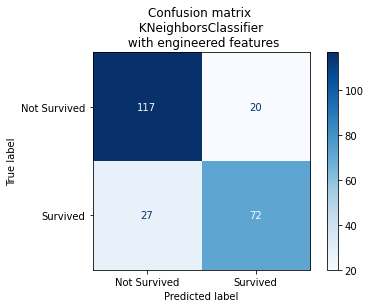

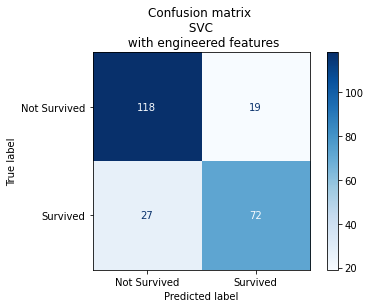

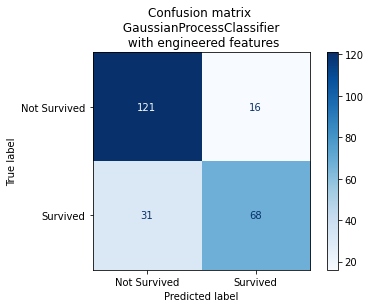

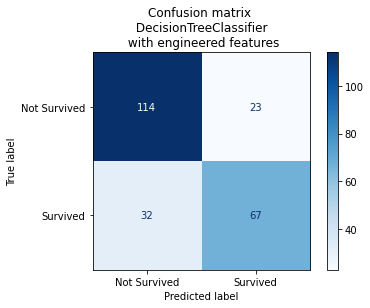

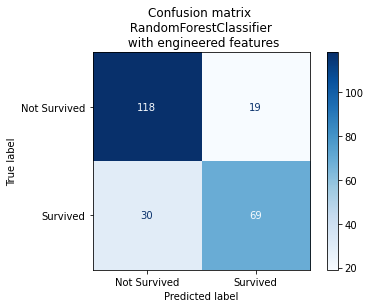

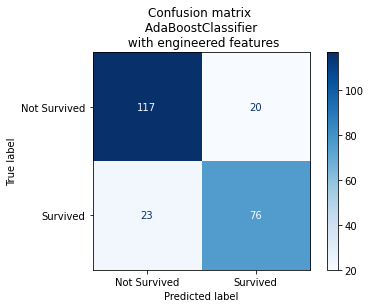

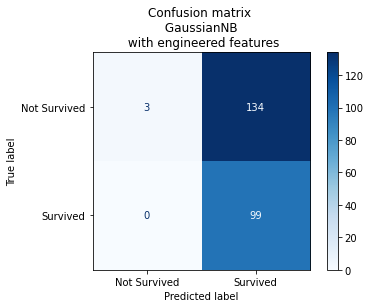

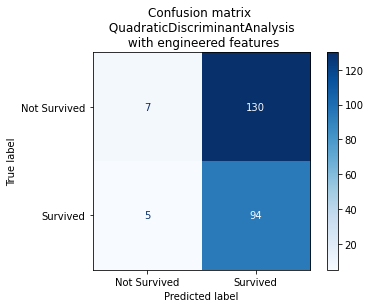

In [44]:
accuracies = evaluate(df_ml, cls_lst, tqdm_off=False)

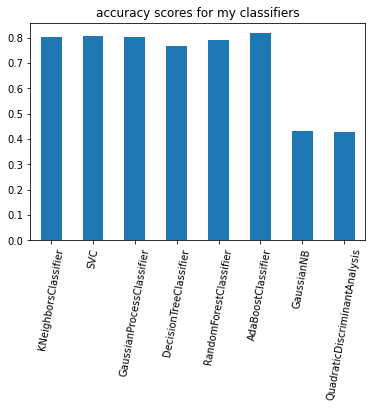

In [45]:
accuracy_df = pd.DataFrame(accuracies, index=[0])

# Flip columns and rows
accuracy_df = accuracy_df.T

# Plot result
accuracy_df.plot(kind='bar',
                 legend=False,
                 rot=80,
                 title='accuracy scores for my classifiers');

# Modularizing functions

**Purpose**: Don't overcrowd your notebook with stuff that you don't need (think: putting away tools from a workbench if you don't use them)

In general you have two options

**Option 1**

1. place your function `my_function` in a `my_module.py` file right next to this notebook.
2. import with `from my_module import my_function` and use `my_function` in ordinary fashion

Modularize semantically, e.g. one module containing functions for cleaning data, one module for evaluating etc... 

**Option 2**

Only if you need one semantic level more of ordering your functions: Place modules with functions in them in **packages**
1. Place `.py` files from *Option 1* in a folder which is in the same folder as your notebook. The name of that is the package name. Let's say it's `my_package`.
2. Import your functions with `from my_package.my_module import my_function`

In both cases keep in mind to also import necessary modules into these `.py` files, that the functions in there need.

/home/flo/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'KNeighborsClassifier': 0.8008474576271186,
 'SVC': 0.8050847457627118,
 'GaussianProcessClassifier': 0.8008474576271186,
 'DecisionTreeClassifier': 0.7584745762711864,
 'RandomForestClassifier': 0.8008474576271186,
 'AdaBoostClassifier': 0.8177966101694916,
 'GaussianNB': 0.4322033898305085,
 'QuadraticDiscriminantAnalysis': 0.4279661016949153}

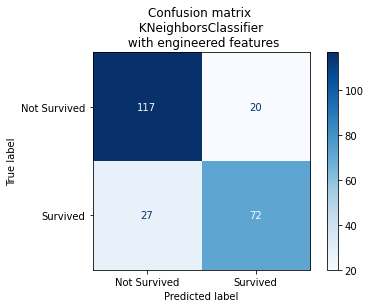

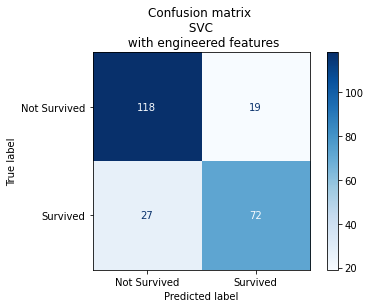

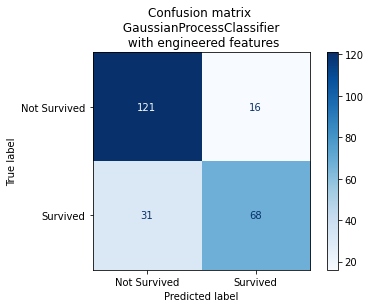

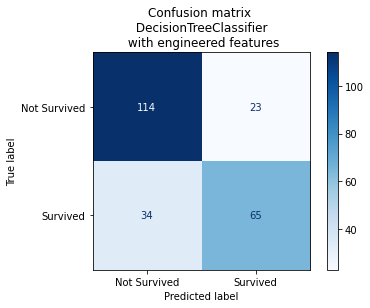

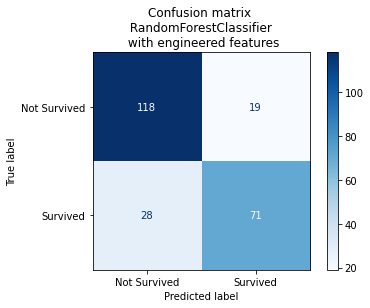

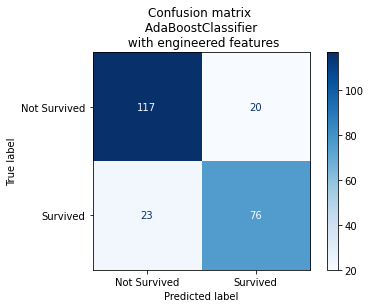

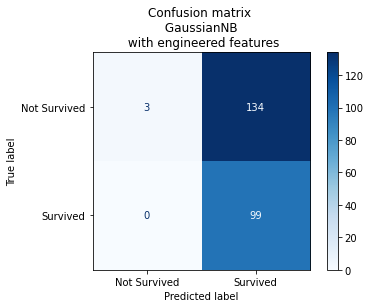

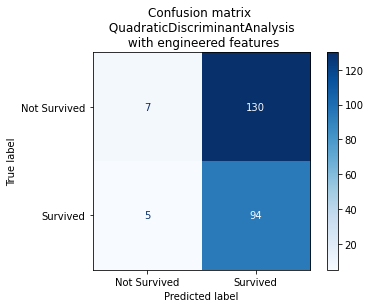

In [46]:
# Importing the function from a module saved as .py in the same folder as the notebook
import evaluate
evaluate.evaluate(df_ml, cls_lst)

/home/flo/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'KNeighborsClassifier': 0.8008474576271186,
 'SVC': 0.8050847457627118,
 'GaussianProcessClassifier': 0.8008474576271186,
 'DecisionTreeClassifier': 0.7627118644067796,
 'RandomForestClassifier': 0.7966101694915254,
 'AdaBoostClassifier': 0.8177966101694916,
 'GaussianNB': 0.4322033898305085,
 'QuadraticDiscriminantAnalysis': 0.4279661016949153}

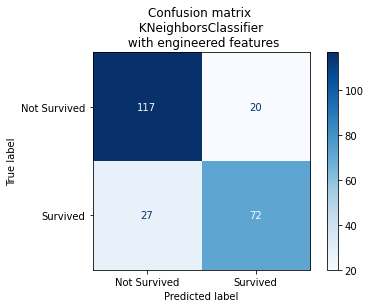

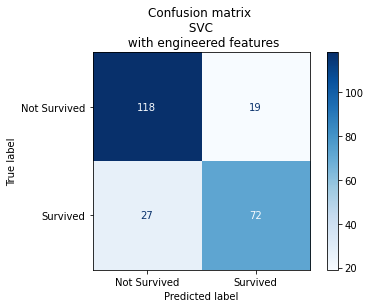

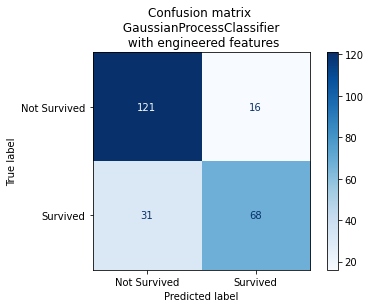

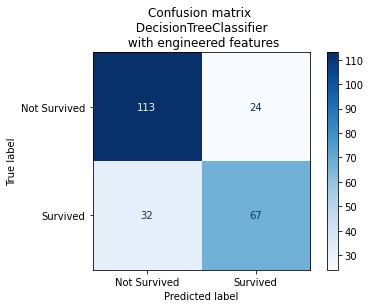

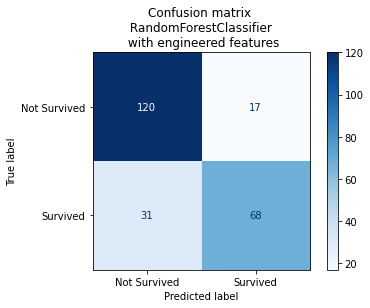

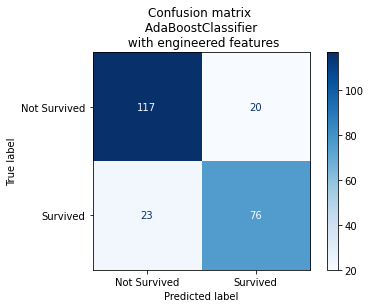

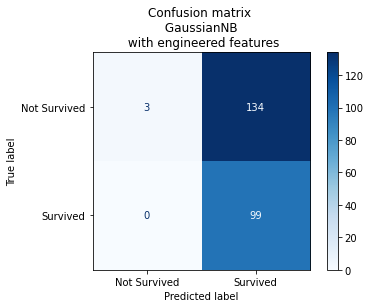

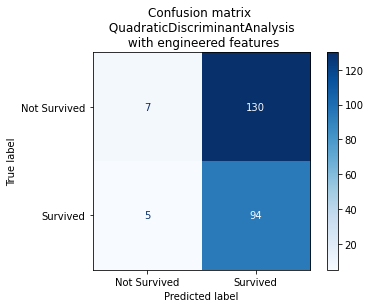

In [47]:
# Importing the function from a module (represented by the .py file)
# from a package (represented by a folder, which is in the same folder as the notebook)
from machine_learning import evaluate
evaluate.evaluate(df_ml, cls_lst)

# Further sources

* 10 simple hacks to speed up your data analysis in Python, [kaggle](https://www.kaggle.com/parulpandey/10-simple-hacks-to-speed-up-your-data-analysis)